# CITS4403 Slime Mould Project
## Wenxiao Zhang 22792191

**set up this project**
1. create a file named `environment.yml`
2. copy the following code into `environment.yml`
```
name: slime
dependencies:
    - jupyter
    - pillow
    - python=3.10.6
    - pip
    - pip:
      - numpy
      - matplotlib
      - pandas
      - geopandas
      - networkx
      - scipy
      - empiricaldist
```

3. Installing [conda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html)
4. Creating conda environment
    - `conda env create -f environment.yml`
5. Configuring the environment `slime` in Jupyter notebook
6. Running the code below

## Import libraries

In [370]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
import math
from empiricaldist import Pmf
import random
from collections import deque
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
import os

if not os.path.exists(os.getcwd()+ '\\output'):
    os.makedirs(os.getcwd()+'\\output')

## Util Functions

In [371]:
def degrees(G):
    """List of degrees for nodes in `G`.

    G: Graph object

    returns: list of int
    """
    return [G.degree(u) for u in G]

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

def node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan

    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.mean(edges)


def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            if source != dest:
                yield dist


def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

def savefig(filename, **options):
    """Save the current figure.

    Keyword arguments are passed along to plt.savefig

    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html

    filename: string
    """
    print("Saving figure to file", filename)
    plt.savefig(filename, **options)

def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

def legend(**options):
    """Draws a legend only if there is at least one labeled item.

    options are passed to plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html

    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like

    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties

    https://matplotlib.org/api/axes_api.html

    In addition, you can use `legend=False` to suppress the legend.

    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()

## Load and preprocess the dataset 

In [372]:
stations = gpd.read_file('toronto_nodes.geojson')
# routes = gpd.read_file('toronto_edges.geojson')
# drop irrelevant columns and null value
stations = stations.drop(['name', 'marker-symbol', 'marker-size'], axis=1)
# routes = routes.drop(['name', 'ref'], axis=1).reset_index()
stations = stations[~stations['marker-color'].isnull()].reset_index().drop(['index', 'marker-color'], axis=1)

### Preprocess nodes

In [373]:
stations['lon'], stations['lat'] = stations.geometry.x, stations.geometry.y
stations['value'] = 4
min_lon = min(stations['lon'])
min_lat = min(stations['lat'])
# scaling lon lat values
stations['x'] = stations.lon.apply(lambda x: int((x - min_lon) * (10**3)))
stations['y'] = stations.lat.apply(lambda y: int((y - min_lat) * (10**3)))
# subset the data
# stations = stations[((stations['x']>150) & (stations['x']<500)) & ((stations['y']>530) & (stations['y']<800))]
min_x = min(stations['x'])
min_y = min(stations['y'])
stations['x'] = stations.x.apply(lambda x: int(x - min_x)+10)
stations['y'] = stations.y.apply(lambda y: int(y - min_y)+10)
stations['nodes'] = stations[['x', 'y']].apply(tuple, axis=1)
stations = stations.drop_duplicates(subset=['nodes'])
stations.head()


,geometry,lon,lat,value,x,y,nodes
0,POINT (0.05799 43.64766),0.057993,43.647657,4,67,12,"(67, 12)"
1,POINT (0.05597 43.65061),0.055970,43.650614,4,65,15,"(65, 15)"
2,POINT (0.0622 43.64522),0.062198,43.645221,4,72,10,"(72, 10)"
3,POINT (0.05445 43.65483),0.054453,43.654831,4,64,19,"(64, 19)"
4,POINT (0.06494 43.64915),0.064941,43.649152,4,74,13,"(74, 13)"


### Preprocess edges

In [374]:
# routes['nodes'] = "None"
# selected_stations = set()
# for i, route in routes.iterrows():
#     nodes = [None] * len(route['geometry'].coords)
#     for k, station in stations.iterrows():
#         point = station['geometry']
#         if route['geometry'].distance(point) < 1e-3:
#             min_dist = -1
#             min_j = 0
#             for j, node in enumerate(route['geometry'].coords):
#                 idx = (point.x, point.y)
#                 dist = math.dist(node, idx) 
#                 if dist < min_dist or min_dist == -1:
#                     min_dist = dist
#                     min_j = j
#             if nodes[min_j] is not None:
#                 min_j += 1
#             nodes[min_j] = station['nodes']
#     nodes = [x for x in nodes if x]
#     routes.at[i, 'nodes'] = nodes
# routes = routes[routes['nodes'].map(lambda d: len(d)) > 0]
# routes.head()

## Visualise the data in NetworkX

In [375]:
# G = nx.Graph()
# for nodes in routes['nodes']:
#     for seg_start, seg_end in zip(nodes, nodes[1:]):
#         G.add_edge(seg_start, seg_end)
# positions = {n: [n[0], n[1]] for n in list(G.nodes)}

# fig = plt.figure(figsize=(6.3, 5))
# nx.draw(G, positions, 
#         node_color='C1', 
#         node_shape='s', 
#         node_size=12, 
#         with_labels=False)
# savefig('output/original_graph.png')

## Slime Mould

### Cell

In [376]:
class Cell:
    def __init__(self, pheromone=0., cell_type=0):
        self.pheromone = pheromone
        self.cell_type = cell_type

    def get_cell_type(self):
        return self.cell_type


### Food

In [377]:
class FoodCell(Cell):
    def __init__(self, food_id: int, food_idx: tuple):
        super().__init__(pheromone=10., cell_type=2)
        self.food_id = food_id
        self.food_idx = food_idx
        self.pheromone = 10.

    def get_food_idx(self):
        return self.food_idx

    def get_food_id(self):
        return self.food_id


### Slime

In [378]:
DIFFUSION_THRESHOLD = 3.5
DIFFUSION_DECAY_RATE = 1.26
DISTANCE_FOR_DIFFUSION_THRESHOLD = 55
MOVING_THRESHOLD = 1
MAX_PH = 5.5
MAX_PH_INCREASE_STEP = 0.2


def get_neighbours(idx):
    """
    get the tuple index of the neighbours of the input slime cell
    :param idx: the tuple index of the given slime cell
    :return: the tuple index of the neighbours
    """
    return [
        (idx[0] - 1, idx[1] - 1),  # up   1, left  1
        (idx[0] - 1, idx[1]),  # up   1,
        (idx[0] - 1, idx[1] + 1),  # up   1, right 1
        (idx[0], idx[1] - 1),  # , left  1
        (idx[0], idx[1] + 1),  # , right 1
        (idx[0] + 1, idx[1] - 1),  # down 1, left  1
        (idx[0] + 1, idx[1]),  # down 1,
        (idx[0] + 1, idx[1] + 1),  # down 1, right 1
    ]


def step_direction(index: int, idx: tuple):
    """
    get the next main diffusion step of the slime cell
    :param index: direction index
    :param idx: the tuple index of the slime cell
    :return: the tuple index of the next main diffusion step
    """
    next_step = {
        0: (0, 0),
        1: (-1, -1),
        2: (1, -1),
        3: (-1, 1),
        4: (1, 1),
        5: (-1, 0),
        6: (1, 0),
        7: (0, -1),
        8: (0, 1)
    }
    return next_step[index][0] + idx[0], next_step[index][1] + idx[1]


class SlimeCell(Cell):

    def __init__(self, idx: tuple, pheromone: float, mould, dish, is_capital):
        super().__init__(pheromone=pheromone, cell_type=1)

        self.idx = idx
        self.pheromone = pheromone
        self.max_ph = 4
        self.direction = None
        self.is_capital = is_capital
        self.reached_food_id = None
        self.mould = mould
        self.dish = dish
        self.food_path = []

        # (food_id, food_idx)
        self.step_food = None
        self.curr_target = None

    def find_nearest_food(self, food_ids):
        """
        find the nearest food of the slime cell
        :param food_ids: a list of food ids
        :return: min_i: the nearest food id, min_dist: distance
        """
        min_dist = -1
        min_i = 0
        # find the nearest food
        for i in food_ids:
            food_idx = self.dish.get_food_position(i)
            dist = math.dist(self.idx, food_idx)
            if min_dist > dist or min_dist < 0:
                min_dist = dist
                min_i = i
        return min_i, min_dist

    def set_reached_food_path(self):
        """
        setup the food path the slime cell will go through
        """
        # target food (food_id, food_idx)
        target_food_id = self.mould.get_current_target()[0]
        self.curr_target = target_food_id

        mould_reached_food_ids = self.mould.get_reached_food_ids()

        if len(mould_reached_food_ids) == 0:
            self.food_path.append(self.mould.get_current_target()[0])

        else:
            # find the nearest food
            min_i = self.find_nearest_food(food_ids=self.mould.get_reached_food_ids())[0]

            nearest_target = self.mould.get_nearest_connected_target()
            if nearest_target != -1:
                # find the shortest path from the nearest food to the target food
                self.food_path = nx.shortest_path(G=self.dish.get_food_graph(), source=min_i,
                                                  target=nearest_target)
            else:
                self.food_path.append(min_i)
            self.food_path.append(target_food_id)
        step_food_id = self.food_path.pop(0)
        self.step_food = (step_food_id, self.dish.get_food_position(step_food_id))

    def reset_step_food(self):
        """
        The step food is the food in the food path the slime cell will go next.
        reset the step food of the current slime cell
        """
        # reached target
        if self.reached_food_id == self.curr_target and self.curr_target == self.mould.get_current_target()[0]:
            return

        if self.step_food is None or len(self.food_path) == 0:
            self.set_reached_food_path()
        else:
            # reached step food
            step_food_idx = self.dish.get_food_position(self.step_food[0])
            if math.dist(step_food_idx, self.idx) < 3:
                step_food_id = self.food_path.pop(0)
                self.step_food = (step_food_id, self.dish.get_food_position(step_food_id))

    def sensory(self):
        """
        set up the next main diffusion direction based on the location of the step food
        """
        # target_food = self.mould.get_current_target()
        # food_idx = target_food[1]
        if self.reached_food_id == self.step_food:
            self.reset_step_food()
        food_idx = self.step_food[1]

        # (-1, -1)
        if food_idx[0] < self.idx[0] and food_idx[1] < self.idx[1]:
            self.direction = 1
        # (1, -1)
        elif food_idx[0] > self.idx[0] and food_idx[1] < self.idx[1]:
            self.direction = 2
        # (-1, 1)
        elif food_idx[0] < self.idx[0] and food_idx[1] > self.idx[1]:
            self.direction = 3
        # (1, 1)
        elif food_idx[0] > self.idx[0] and food_idx[1] > self.idx[1]:
            self.direction = 4
        # (-1, 0)
        elif food_idx[0] < self.idx[0]:
            self.direction = 5
        # (1, 0)
        elif food_idx[0] > self.idx[0]:
            self.direction = 6
        # (0, -1)
        elif food_idx[1] < self.idx[1]:
            self.direction = 7
        # (0, 1)
        elif food_idx[1] > self.idx[1]:
            self.direction = 8

    @staticmethod
    def check_boundary(idx, lattice_shape):
        """
        check if the neighbour cell reached the boundary of the lattice
        :param idx: the location of the neighbour cell
        :param lattice_shape: the shape of the lattice
        :return: false if reach boundary, else true
        """
        if idx[0] >= lattice_shape[0] or idx[0] <= 0 or idx[1] >= lattice_shape[1] or idx[1] <= 0:
            return False
        return True

    # diffusion
    def diffusion(self, lattice, decay):
        """
        the slime cell will check all the 8 neighbours and perform diffusion based on conditions
        1. perform diffusion on the next main diffusion direction first
        2. perform diffusion on the rest cells if not reach DIFFUSION THRESHOLD
        3. Take different diffusion strategies when the neighbour cell is empty, slime, food, boundary
        4. the pheromone of the slime cell will decrease after the diffusion is performed each time.
        :param lattice: dish lattice
        :param decay: the rate for decreasing the pheromone of the slime cell
        """
        new_idx = step_direction(self.direction, self.idx)
        neighbours = get_neighbours(self.idx)

        # make sure the first neighbour is the next step
        neighbours.remove(new_idx)
        neighbours = deque(neighbours)
        neighbours.appendleft(new_idx)

        while neighbours:
            neigh = neighbours.popleft()
            # continue if the neighbor is out of boundary
            if not self.check_boundary(neigh, lattice.shape):
                continue
            neigh_cell = lattice[neigh]
            # neighbour cell is an empty cell
            if neigh_cell.get_cell_type() == 0:

                # next main diffusion place is an empty cell
                if neigh == new_idx and self.pheromone > MOVING_THRESHOLD:
                    # self.mould.update_slime_cell(new_idx, self)
                    self.mould.slime_cell_generator(idx=neigh, pheromone=self.pheromone, decay=decay,
                                                    is_capital=self.is_capital)
                    self.pheromone *= (1 - DIFFUSION_DECAY_RATE * decay)

                    self.is_capital = False
                    continue

                # neighbour cell is a random diffusion cell
                if self.pheromone > DIFFUSION_THRESHOLD and \
                        self.find_nearest_food(self.mould.get_reached_food_ids())[1] < DISTANCE_FOR_DIFFUSION_THRESHOLD:
                    self.mould.slime_cell_generator(idx=neigh, pheromone=self.pheromone/DIFFUSION_DECAY_RATE, decay=decay)
                    self.pheromone *= (1 - (2 * DIFFUSION_DECAY_RATE * decay))

            # neighbor is a slime
            elif neigh_cell.get_cell_type() == 1:

                # next main diffusion place is a slime cell
                if neigh == new_idx and self.pheromone > MOVING_THRESHOLD:
                    neigh_increase_ph = neigh_cell.pheromone + self.pheromone / DIFFUSION_DECAY_RATE
                    if neigh_increase_ph > neigh_cell.max_ph:

                        neigh_cell.pheromone = neigh_cell.max_ph

                    else:
                        neigh_cell.pheromone = neigh_increase_ph
                    self.pheromone /= DIFFUSION_DECAY_RATE

                    self.mould.update_slime_cell(new_idx, neigh_cell)

                # neighbor bigger than self
                # increase self-pheromone when find neighbor nearby
                if neigh_cell.pheromone > self.pheromone and self.max_ph < MAX_PH:
                    self.max_ph += MAX_PH_INCREASE_STEP
                    self.pheromone += (neigh_cell.pheromone / 10)

            # add pheromone if current cell find food nearby
            elif neigh_cell.get_cell_type() == 2:

                # eat food
                self.pheromone = 7
                self.max_ph = 7
                self.reached_food_id = neigh_cell.get_food_id()
                new_food_id = neigh_cell.get_food_id()
                if new_food_id not in self.mould.get_reached_food_ids():
                    self.mould.update_food_connection(new_food_id)
                    self.mould.get_reached_food_ids().add(new_food_id)

        self.mould.update_slime_cell(self.idx, self)

    def step(self, lattice, decay):
        """
        The sensory stage: all slime cells adjust their direction based on the food
        The diffusion stage: all pheromones undergo diffusion
        """
        self.sensory()
        self.diffusion(lattice, decay)

    def get_idx(self):
        return self.idx

    def get_pheromone(self):
        return self.pheromone

    def set_pheromone(self, ph):
        self.pheromone = ph

    def get_reached_food_id(self):
        return self.reached_food_id

    def remove_capital(self):
        self.is_capital = False


### Mould

In [379]:
TARGET_SWITCH_THRESHOLD = 5


def get_corner_slime_cells(slime_cells, current_direction, direction_list=None):
    """
    get the slime cell in the corner of the mould for deciding the next target food
    :return: the slime cell in the selected corner
    """
    slime_idx = slime_cells.keys()
    curr_capital_slime = None
    if current_direction == 0:
        curr_capital_slime = slime_cells[min(slime_idx)]
    elif current_direction == 1:
        max_x = max([x for x, y in slime_idx])
        for x, y in slime_idx:
            if x == max_x:
                curr_capital_slime = slime_cells[(x, y)]
                break
    elif current_direction == 2:
        min_y = min([y for x, y in slime_idx])
        for x, y in slime_idx:
            if y == min_y:
                curr_capital_slime = slime_cells[(x, y)]
                break
    elif current_direction == 3:
        curr_capital_slime = slime_cells[max(slime_idx)]
    if curr_capital_slime.get_reached_food_id() is not None:
        if direction_list is not None:
            direction_list.remove(current_direction)
        else:
            direction_list = [0, 1, 2, 3]
        get_corner_slime_cells(slime_cells, random.choice(direction_list))
    return curr_capital_slime


class Mould:
    def __init__(self, dish, start_loc: tuple, mould_shape: tuple, init_mould_coverage: float, decay: float):
        self.dish = dish
        self.decay = decay
        self.slime_cells = {}
        self.mould_shape = mould_shape
        self.reached_food_ids = set()
        self.current_target = 0
        self.nearest_connected_target = -1
        self.capital_slime = None
        self.initialise(start_loc, mould_shape, init_mould_coverage)

        self.avg_ph = []
        self.total_num = []
        self.total_active_num = []
        self.total_inactive_num = []
        self.total_reached_foods = []
        self.coverage_ratio = []

        self.target_switch_count = 0

    def remove_slime_cell(self, idx):
        """
        remove the slime cell in the lattice
        :param idx: the tuple index of the slime cell
        """
        self.dish.set_lattice(idx, Cell())
        del self.slime_cells[idx]

    def update_slime_cell(self, idx, slime: SlimeCell):
        """
        update the lattice when changes made by a slime cell
        :param idx: the tuple index to be updated
        :param slime: the slime cell to be updated
        """
        if idx is None or slime is None:
            return
        self.slime_cells[idx] = slime
        self.dish.set_lattice(idx, slime)

    def initialise(self, start_loc, mould_shape, init_mould_coverage):
        """
        initialise the mould
        :param start_loc: the start location of the mould
        :param mould_shape: the size of the initial mould
        :param init_mould_coverage: the coverage rate of the initial mould
        """
        for x in start_loc[0] - mould_shape[0], start_loc[0] + mould_shape[0]:
            for y in start_loc[1] - mould_shape[1], start_loc[1] + mould_shape[1]:
                if random.random() < init_mould_coverage and (x, y) not in self.dish.get_all_foods_idx():
                    self.slime_cell_generator(idx=(x, y))
        self.setup_capital_slime()
        self.update_target_food()

    def setup_capital_slime(self):
        """
        set up the capital slime to decide the next target food of the mould
        """
        if self.capital_slime is not None:
            previous_capital_slime = self.capital_slime
            previous_capital_slime.remove_capital()
            self.update_slime_cell(previous_capital_slime.get_idx(), previous_capital_slime)
        self.capital_slime = get_corner_slime_cells(self.slime_cells, random.choice([0, 1, 2, 3]))
        self.update_slime_cell(self.capital_slime.get_idx(), self.capital_slime)

    def slime_cell_generator(self, idx, pheromone=None, decay=0, is_capital=False):
        """
        generate a slime cell
        :param idx: the tuple index to generate a slime cell
        :param pheromone: the pheromone value of the slime cell
        :param decay: the decay rate of the slime cell
        :param is_capital: set the next slime cell to be the capital slime if true
        :return: the generated slime cell
        """
        if pheromone is None:
            pheromone = 8. * (1 - decay)
        slime_cell = SlimeCell(idx=idx, pheromone=pheromone, mould=self, dish=self.dish, is_capital=is_capital)
        if slime_cell.is_capital:
            self.capital_slime = slime_cell
        self.update_slime_cell(slime_cell.get_idx(), slime_cell)
        return slime_cell

    def find_nearest_connected_food(self, food_id):
        """
        find the nearest connected food to the target food.
        :param food_id: the id of the target food
        :return: the nearest connected food to the target food
        """
        min_dist = -1
        min_i = -1
        food_idx = self.dish.get_food_position(food_id)
        for i in self.reached_food_ids:
            if i == food_id:
                continue
            reachable_food_idx = self.dish.get_food_position(i)
            dist = math.dist(food_idx, reachable_food_idx)
            if min_dist > dist or min_dist == -1:
                min_dist = dist
                min_i = i
        return min_i

    def update_food_connection(self, food_id):
        """
        update the connection of the food in the food graph
        :param food_id: the id of the food to be connected
        """
        if len(self.reached_food_ids) == 0:
            return
        self.nearest_connected_target = self.find_nearest_connected_food(food_id)
        if not self.dish.get_food_graph().has_edge(food_id, self.nearest_connected_target):
            self.dish.add_food_edge(food_id, self.nearest_connected_target)

    def update_target_food(self):
        """
        switch the target food
        """
        # set a target food
        remaining_food_ids = set(self.dish.get_all_foods().keys()) - self.reached_food_ids
        min_i = self.capital_slime.find_nearest_food(remaining_food_ids)[0]
        if min_i != self.current_target:
            self.current_target = (min_i, self.dish.get_food_position(min_i))
            # update the connection to the target food from reachable food
            self.nearest_connected_target = self.find_nearest_connected_food(min_i)
            # optional
            self.update_food_connection(min_i)

    def update_slime(self):
        """
        update statistics of the mould and
        update each slime after each evolution step of the mould
        """
        # update statistics after each evolution
        active_slime = [slime.pheromone for slime in list(self.slime_cells.values())
                        if slime.pheromone > 1]
        average_pheromone = np.average(active_slime)
        self.avg_ph.append(average_pheromone)
        self.total_num.append(len(self.slime_cells))
        self.total_active_num.append(len(active_slime))
        self.total_inactive_num.append(len(self.slime_cells) - len(active_slime))
        self.total_reached_foods.append(len(self.reached_food_ids))
        self.coverage_ratio.append(len(self.slime_cells)/self.dish.get_dish_size())

        if self.target_switch_count > TARGET_SWITCH_THRESHOLD or \
                self.capital_slime.get_reached_food_id() is not None or self.current_target[0] in self.reached_food_ids:
            self.target_switch_count = 0
            self.setup_capital_slime()
            self.update_target_food()

    def evolve(self):
        """
        the evolution step of the mould,
        every slime cell in the mould will take a step during each evolution step
        """
        previous_reached_foods = len(self.reached_food_ids)
        slime_idx = list(self.slime_cells.keys())
        for idx in slime_idx:
            self.dish.get_lattice()[idx].step(self.dish.get_lattice(), self.decay)
        if len(self.reached_food_ids) == previous_reached_foods:
            self.target_switch_count += 1
        self.update_slime()

    def get_current_target(self):
        return self.current_target

    def get_reached_food_ids(self):
        return self.reached_food_ids

    def get_avg_ph(self):
        return self.avg_ph

    def get_total_num(self):
        return self.total_num

    def get_total_active_num(self):
        return self.total_active_num

    def get_total_inactive_num(self):
        return self.total_inactive_num

    def get_coverage_ratio(self):
        return self.coverage_ratio

    def get_total_reached_foods(self):
        return self.total_reached_foods

    def get_nearest_connected_target(self):
        return self.nearest_connected_target


### Dish

In [380]:
class Dish:
    def __init__(self, dish_shape: tuple, foods: pd.DataFrame, start_loc: tuple, mould_shape: tuple, init_mould_coverage: float,
                 decay: float):
        self.lattice = self.initialise_dish(dish_shape)
        self.dish_size = dish_shape[0] * dish_shape[1]
        self.all_foods = {}
        self.all_foods_idx = []
        self.food_positions = {}
        self.food_graph = nx.Graph()
        self.initialise_food(foods)
        self.mould = self.initialise_slime_mould(self, start_loc, mould_shape, init_mould_coverage, decay)

    @staticmethod
    def initialise_dish(dish_shape):
        """
        initialise the dish lattice
        :param dish_shape: the shape of the dish lattice
        :return: dish lattice
        """
        lattice = np.empty(dish_shape, object)
        for i in np.ndindex(dish_shape):
            lattice[i] = Cell()
        return lattice

    def initialise_food(self, foods):
        """
        Adds food cells in a square with length size
        """
        for i, station in foods.iterrows():
            idx = (station['x'], station['y'])
            value = station['value']

            self.food_positions[i] = idx

            for x in range(value // 2):
                for y in range(value // 2):
                    food_idx = (idx[0] - x, idx[1] - y)
                    food = FoodCell(food_id=i, food_idx=food_idx)
                    self.lattice[food_idx] = food

                    # add food idx
                    self.all_foods_idx.append(food_idx)

                    # add all foods
                    if i not in self.all_foods:
                        self.all_foods[i] = [food]
                    else:
                        self.all_foods[i].append(food)

        self.food_graph.add_nodes_from(self.food_positions)

    @staticmethod
    def initialise_slime_mould(dish, start_loc, mould_shape, init_mould_coverage, decay):
        """
        initialise the mould
        """
        return Mould(dish, start_loc, mould_shape, init_mould_coverage, decay)

    @staticmethod
    def pheromones(lattice):
        """
        Returns a lattice of just the pheromones to draw the graph
        """
        pheromones = np.zeros_like(lattice, dtype=float)
        for i in np.ndindex(lattice.shape):
            pheromones[i] = lattice[i].pheromone
        return pheromones

    def draw_pheromones(self, cmap='YlOrRd'):
        """Draws the cells."""
        data = self.pheromones(self.lattice)
        data = data.T

        return plt.imshow(self.pheromones(self.lattice),
                          cmap=cmap,
                          vmin=0, vmax=10,
                          interpolation='none',
                          origin='lower', extent=[0, data.shape[1], 0, data.shape[0]])

    def animate(self, frames=10, interval=200, filename=None):
        """
        Returns an animation
        """
        fig = plt.figure(figsize=(6.3, 5))

        im = self.draw_pheromones()
        plt.axis('tight')
        plt.axis('image')
        plt.tick_params(which='both',
                        bottom=False,
                        top=False,
                        left=False,
                        right=False,
                        labelbottom=False,
                        labelleft=False)

        def func(frame):
            self.mould.evolve()
            im.set_data(self.pheromones(self.lattice).T)
            return [im]

        ani = FuncAnimation(fig, func, frames=frames, blit=True, interval=interval)
        fps = 1 / (interval / 1000)
        filename is not None and ani.save(filename, dpi=150, writer=PillowWriter(fps=fps))
        return ani

    def get_all_foods_idx(self):
        return self.all_foods_idx

    def get_all_foods(self):
        return self.all_foods

    def get_lattice(self):
        return self.lattice

    def set_lattice(self, idx, obj):
        self.lattice[idx] = obj

    def get_food_nodes(self):
        return self.food_graph.nodes()

    def get_food_position(self, food_id):
        return self.food_positions[food_id]

    def add_food_edge(self, source, target):
        self.food_graph.add_edge(source, target)

    def get_food_graph(self):
        return self.food_graph

    def get_dish_size(self):
        return self.dish_size

### Intialise Dish

In [381]:
start_loc = (stations.at[0,'x'], stations.at[0,'y'])
dish = Dish(dish_shape=(max(stations.x) + 10, max(stations.y) + 10), foods=stations, start_loc=start_loc, mould_shape=(5, 5), init_mould_coverage=1, decay=0.2)

### Animate 50 steps

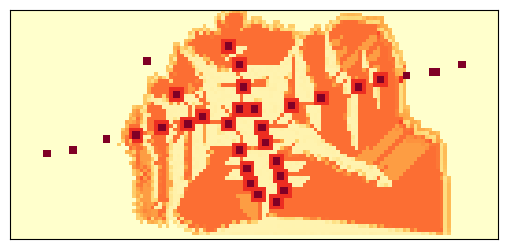

In [382]:
dish.animate(frames=50, interval=100, filename="output/50steps.gif")
plt.show()

Saving figure to file output/slime_graph_50steps.png


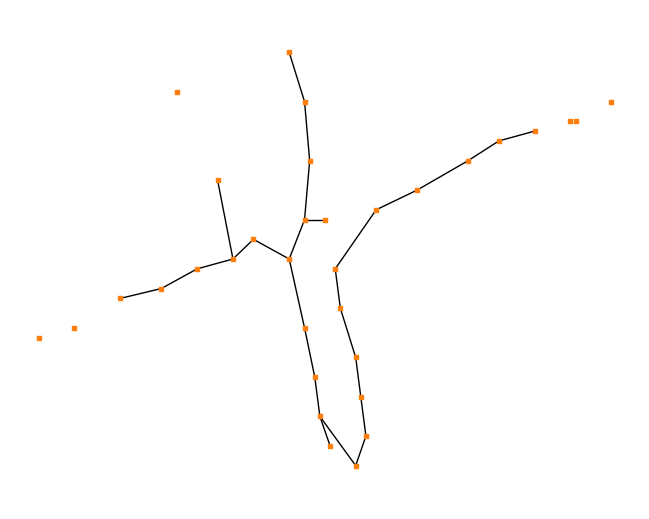

In [383]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_50steps.png')

### Animate 50 + 100 steps

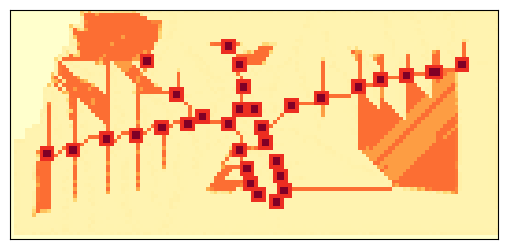

In [384]:
dish.animate(frames=100, interval=100, filename="output/150steps.gif")
plt.show()

Saving figure to file output/slime_graph_150steps.png


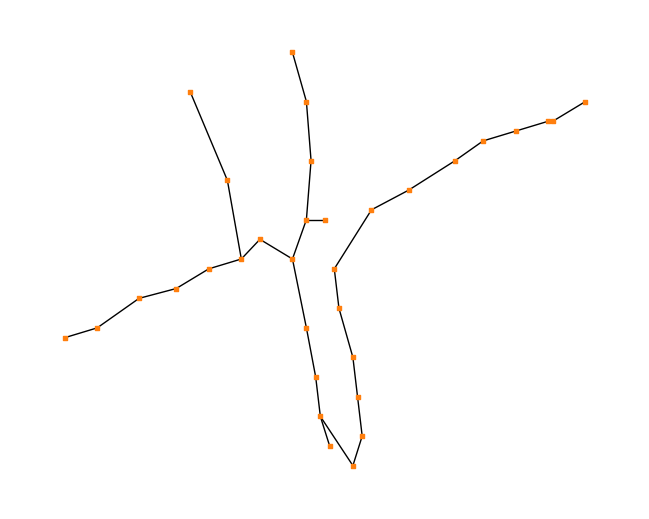

In [385]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_150steps.png')

### Animate 50 + 100 + 100 steps

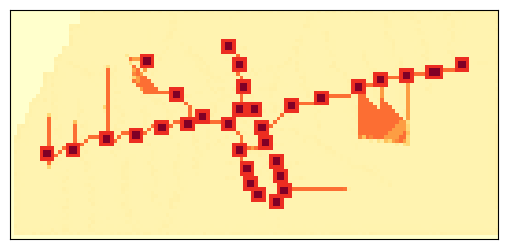

In [386]:
dish.animate(frames=100, interval=100, filename="output/250steps.gif")
plt.show()

Saving figure to file output/slime_graph_250steps.png


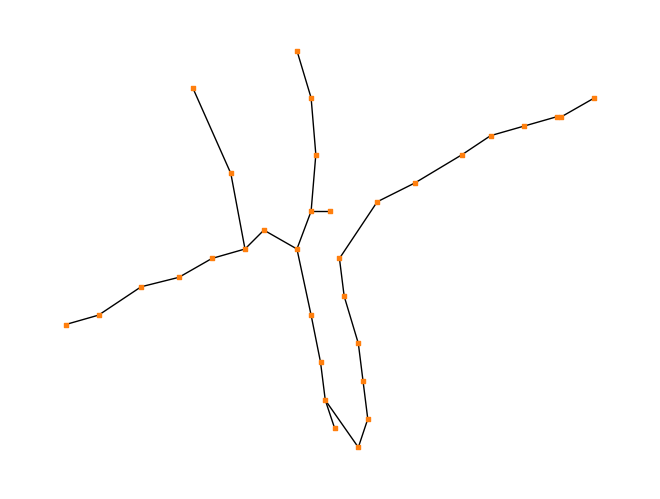

In [387]:
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_250steps.png')

### Animate 50 + 100 + 100 + 100 steps

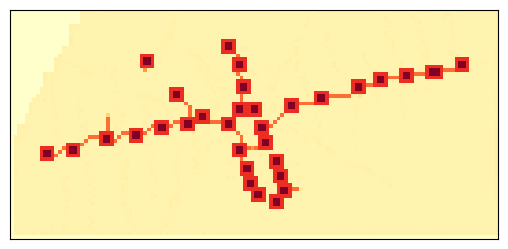

In [388]:
dish.animate(frames=100, interval=100, filename="output/350steps.gif")
plt.show()

Saving figure to file output/slime_graph_350steps.png


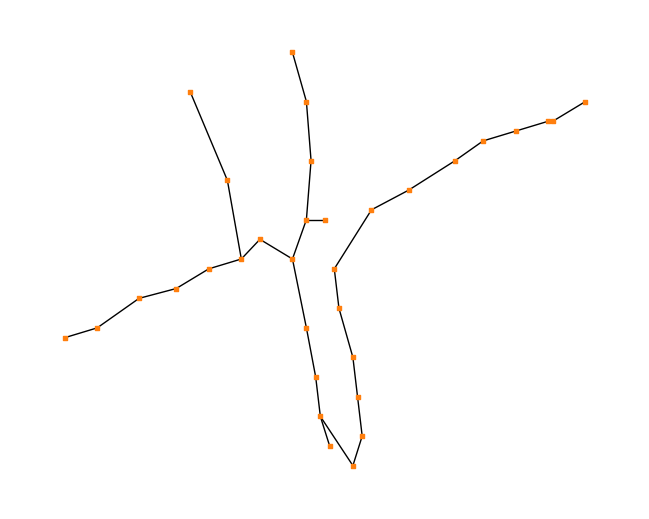

In [389]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
savefig('output/slime_graph_350steps.png')